In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.linalg import hadamard
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO EXPERIMENTO ---
np.random.seed(42)
n_samples = 4000
order = 7  # M=7 (N=8 taps)
N = order + 1

# Gerando sinal de entrada colorido (correlacionado)
# Sinais correlacionados degradam o LMS comum, mas o T-Domain lida bem.
b, a = [1], [1, -0.9] 
x_white = (np.random.randn(n_samples) + 1j * np.random.randn(n_samples)) / np.sqrt(2)
x = np.convolve(x_white, np.exp(-np.arange(10)/2), mode='same') # Filtro de média móvel
x /= np.std(x)

# Planta Desconhecida
w_true = np.array([0.5, -0.4, 0.3, -0.2, 0.1, 0.05, -0.05, 0.01], dtype=complex)
d = np.convolve(x, w_true, mode='full')[:n_samples]
d += 0.01 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

# --- 2. DEFINIÇÃO DA MATRIZ DE TRANSFORMAÇÃO (WALSH-HADAMARD) ---
# Usaremos a matriz de Hadamard como exemplo de transformada genérica.
# Ela deve ser normalizada para ser unitária (H^H * H = I).
H = hadamard(N).astype(complex)
T_matrix = H / np.sqrt(N)

In [3]:
# --- 3. EXECUÇÃO DO FILTRO ---
filt = pdf.TDomainLMS(
    filter_order=order,
    gamma=1e-3,
    alpha=0.05,
    initial_power=1.0,
    transform_matrix=T_matrix,
    step_size=0.05
)

result = filt.optimize(x, d, verbose=True, return_internal_states=True)

[TDomainLMS] Completed in 35.678 ms


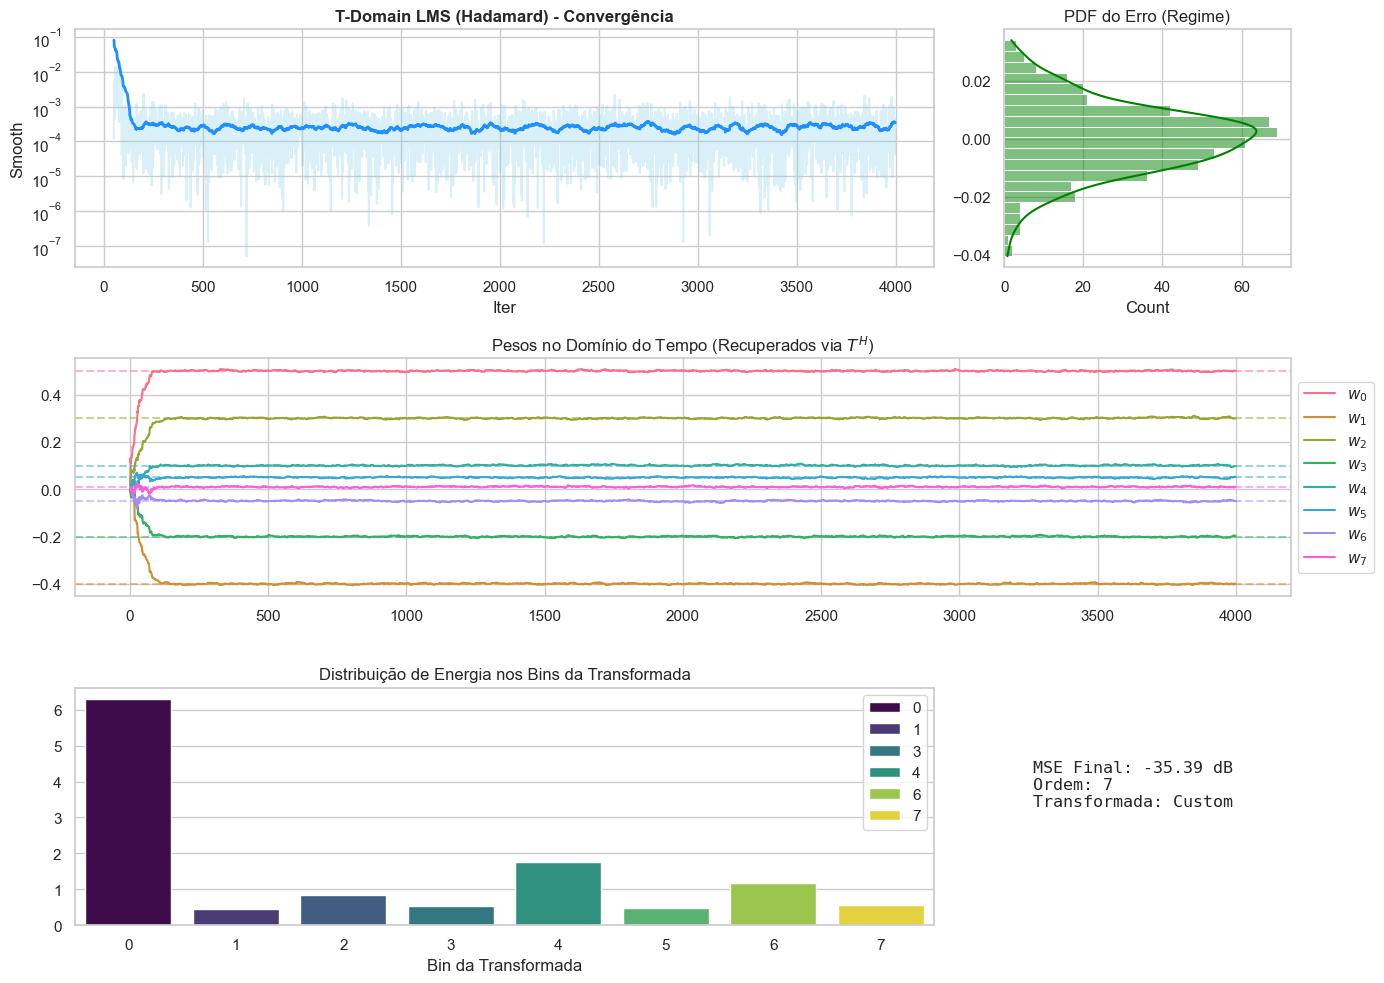

In [4]:
# --- 4. VISUALIZAÇÃO COM SEABORN (FANCY PLOT) ---
# Utilizando a função corrigida para evitar o erro de 'runtime_s'
def plot_tdomain_results(result, w_true, title):
    sns.set_theme(style="whitegrid")
    mse = result.mse()
    coeffs = result.coefficients[1:]
    errors = result.errors
    t = np.arange(len(mse))
    offset = 50

    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, width_ratios=[3, 1], height_ratios=[1, 1, 1])

    # A. Curva de Aprendizado (MSE)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.lineplot(x=t[offset:], y=mse[offset:], ax=ax1, color="skyblue", alpha=0.3)
    mse_df = pd.DataFrame({'Iter': t, 'MSE': mse})
    mse_df['Smooth'] = mse_df['MSE'].rolling(window=50).mean()
    sns.lineplot(x='Iter', y='Smooth', data=mse_df.iloc[offset:], ax=ax1, color="dodgerblue", lw=2)
    ax1.set_yscale('log')
    ax1.set_title(f"{title} - Convergência", fontweight='bold')

    # B. PDF do Erro
    ax2 = fig.add_subplot(gs[0, 1])
    sns.histplot(y=np.real(errors[-500:]), kde=True, ax=ax2, color="green")
    ax2.set_title("PDF do Erro (Regime)")

    # C. Trajetória dos Coeficientes no Tempo
    ax3 = fig.add_subplot(gs[1, :])
    palette = sns.color_palette("husl", coeffs.shape[1])
    for i in range(coeffs.shape[1]):
        sns.lineplot(x=t, y=np.real(coeffs[:, i]), ax=ax3, color=palette[i], label=f'$w_{i}$')
        ax3.axhline(y=np.real(w_true[i]), color=palette[i], linestyle='--', alpha=0.5)
    ax3.set_title("Pesos no Domínio do Tempo (Recuperados via $T^H$)")
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    # D. Energia por Bin da Transformada
    ax4 = fig.add_subplot(gs[2, 0])
    p_last = result.extra["power_vector_last"]
    sns.barplot(x=list(range(len(p_last))), y=p_last, ax=ax4, palette="viridis", hue=list(range(len(p_last))))
    ax4.set_title("Distribuição de Energia nos Bins da Transformada")
    ax4.set_xlabel("Bin da Transformada")

    # E. Métricas
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.axis('off')
    final_mse_db = 10 * np.log10(np.mean(mse[-100:]))
    ax5.text(0.1, 0.5, f"MSE Final: {final_mse_db:.2f} dB\nOrdem: {order}\nTransformada: Custom", 
             fontsize=12, family='monospace', bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

plot_tdomain_results(result, w_true, "T-Domain LMS (Hadamard)")